# sprint17-19-dsb-2017

## タスクの理解

### このタスクを行うことによって、どのような問題が解決できるか

- 細胞核の位置を自動で検出するアルゴリズムを作ることで新薬の研究時間を劇的に短縮できる。

### セグメンテーション

セグメンテーションとはピクセルレベルでのクラス分類のことでこれによって物体のクラスとその輪郭まで正確に推定ができる。

さらにクラス分類だけでなく、細胞核が複数あった場合、「細胞核１、細胞核２、...」と同じクラス内でも別の物体と認識させることを

**インスタンスセグメンテーション**と呼ぶ。


### 評価関数を理解する

今回の評価関数を理解する前提としてIoU（Intersection over union）というものがある。

IoUとはバウンディングボックスの一致度合い（重なり度合い）を示す。

$IoU(A, B) = \frac{A \cap B}{A \cup B} $

一般的に０．５を超えるときによいバウンディングボックスの予測結果とみなす。

この閾値を0から0.1きざみで上げていったときのPrecisionとRecallをプロットの面積率の総和を評価関数とする。


### EDA

EDAカーネルを実行して分かったことを列挙する。

- 細胞核の画像とそのマスク（各細胞核の位置情報）が１つの訓練データとなる
- 画像サイズやカラーかグレースケールなどデータは様々な形式で存在する
- 画像サイズは256×256が最小で最も数が多く、最大サイズは1040×1388
- 細胞核の数は1-375
- ほぼピクセルレベルの細胞核画像もあり縮小すると消えるかもしれないのでリサイズには注意する。

### 画像処理の基本処理

画像処理の基本として下記の３つの処理を行う

- グレースケール変換
- 背景削除
- 核ごとに背景を削除する

#### グレースケール変換

In [82]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[3]
im = imageio.imread(str(im_path))

In [83]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (256, 320, 4)
New image shape: (256, 320)


チャネル数が１つになっていること(RGBAからモノクロ画像)が確認できる。

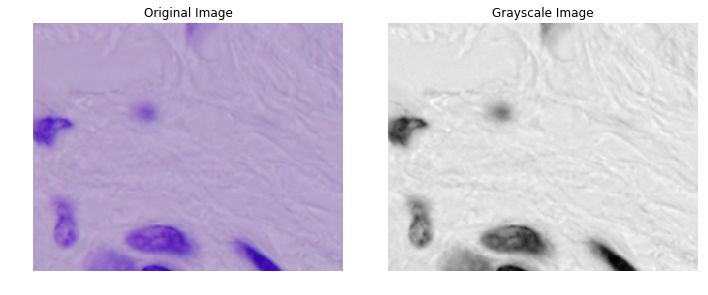

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

# Now, let's plot the data

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

#### 背景削除

大津の二値化によるシンプルな背景削除を行う。

In [97]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

Original image shape: (256, 256, 4)
New image shape: (256, 256)


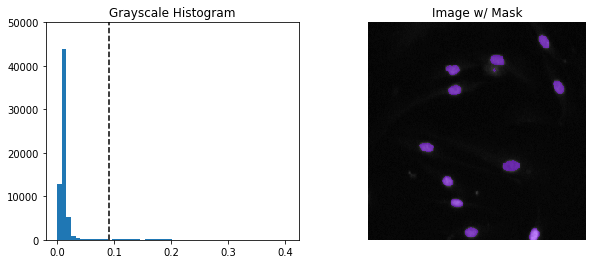

In [98]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

In [99]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 12 separate components / objects detected.


### 核ごとにマスクを作成する

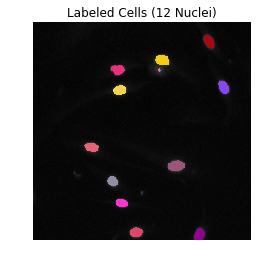

In [100]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [101]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

There are now 12 separate components / objects detected.


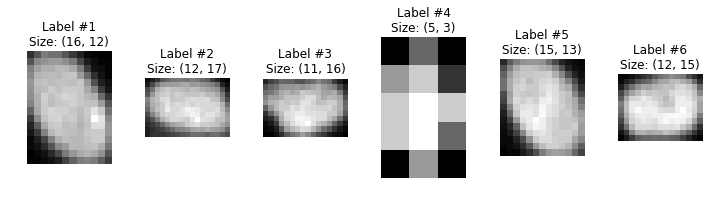

In [102]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

In [103]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

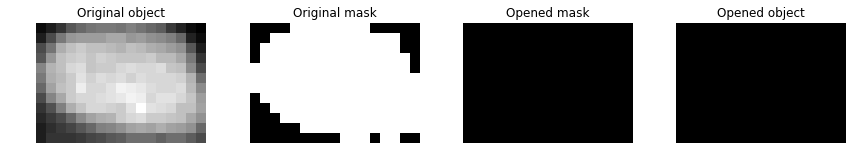

In [104]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### PreProcessing

### Augmentation

Augmentation(データの水増し)にはいろいろな手法があるが、

今回はGaussian Blurを使ってデータを倍に増やした。

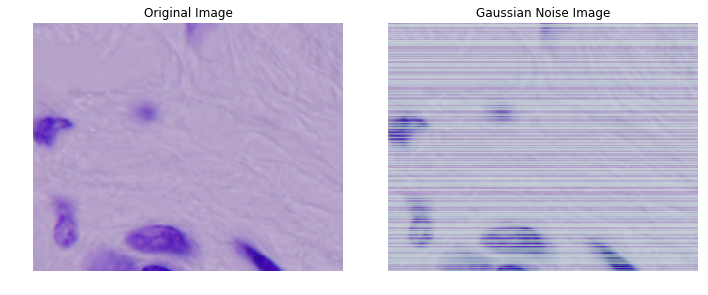

In [118]:
from imgaug import augmenters as iaa


im_path = training_sorted[3]
im = imageio.imread(str(im_path))
    
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 2.0)) # blur images with a sigma of 0 to 3.0
])

images_aug = seq.augment_images(im)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(images_aug)
plt.axis('off')
plt.title('Gaussian Noise Image')

plt.tight_layout()
plt.show()

上記のようなノイズを入れた画像を訓練データとして増やす。

下記コマンドでデータを複製し、複製したものにノイズを加えていく。

cp -r input/stage1_train input_aug/stage1_train/

augmentationの部分はモジュール化し、aug.pyとして同じディレクトリに格納している。

In [157]:
# Glob the training data and load a single image path
training_paths = pathlib.Path('../input_aug/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

# Augumentationの処理を記載
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 1.0)) # blur images with a sigma of 0 to 3.0
])

BASE_DIR = "../input_aug/stage1_train/"

for img_path in training_sorted[1:]:
    print(img_path)
    img = imageio.imread(str(img_path))
    img_aug = seq.augment_images(img)

    imageio.imwrite(str(img_path), img_aug)
    
    

../input_aug/stage1_train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png
../input_aug/stage1_train/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed/images/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png
../input_aug/stage1_train/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/images/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png
../input_aug/stage1_train/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21/images/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21.png
../input_aug/stage1_train/0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426/images/0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426.png
../input_aug/stage1_train/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339/images/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339.pn

../input_aug/stage1_train/1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b/images/1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b.png
../input_aug/stage1_train/14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf/images/14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf.png
../input_aug/stage1_train/15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99/images/15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99.png
../input_aug/stage1_train/150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f/images/150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f.png
../input_aug/stage1_train/1609b1b8480ee52652a644403b3f7d5511410a016750aa3b9a4c8ddb3e893e8e/images/1609b1b8480ee52652a644403b3f7d5511410a016750aa3b9a4c8ddb3e893e8e.png
../input_aug/stage1_train/1631352dbafb8a90f11219fffd3bea368a30bc3bad3bbe0e84e19bd720df4945/images/1631352dbafb8a90f11219fffd3bea368a30bc3bad3bbe0e84e19bd720df4945.pn

../input_aug/stage1_train/24a20f2a529cede5695df2422a3986505b5826bb10b10781d6db2074cf3de7b3/images/24a20f2a529cede5695df2422a3986505b5826bb10b10781d6db2074cf3de7b3.png
../input_aug/stage1_train/27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47/images/27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47.png
../input_aug/stage1_train/2817299fd3b88670e86a9db5651ba24333c299d1d41e5491aabfcd95aee84174/images/2817299fd3b88670e86a9db5651ba24333c299d1d41e5491aabfcd95aee84174.png
../input_aug/stage1_train/2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c/images/2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c.png
../input_aug/stage1_train/28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a/images/28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a.png
../input_aug/stage1_train/295ac4ecf2ee0211c065cf5dbb93b1eb8e61347153447209cd110e9c3e355e81/images/295ac4ecf2ee0211c065cf5dbb93b1eb8e61347153447209cd110e9c3e355e81.pn

../input_aug/stage1_train/37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288/images/37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288.png
../input_aug/stage1_train/3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff/images/3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff.png
../input_aug/stage1_train/3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186/images/3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186.png
../input_aug/stage1_train/3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25/images/3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25.png
../input_aug/stage1_train/3a22fe593d9606d4f137461dd6802fd3918f9fbf36f4a65292be69670365e2ca/images/3a22fe593d9606d4f137461dd6802fd3918f9fbf36f4a65292be69670365e2ca.png
../input_aug/stage1_train/3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9/images/3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9.pn

../input_aug/stage1_train/4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20/images/4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20.png
../input_aug/stage1_train/4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e/images/4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e.png
../input_aug/stage1_train/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607/images/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607.png
../input_aug/stage1_train/4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b/images/4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b.png
../input_aug/stage1_train/4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788bdce17242029745/images/4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788bdce17242029745.png
../input_aug/stage1_train/4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32/images/4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32.pn

../input_aug/stage1_train/5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6/images/5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6.png
../input_aug/stage1_train/5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3/images/5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3.png
../input_aug/stage1_train/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856/images/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856.png
../input_aug/stage1_train/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974/images/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974.png
../input_aug/stage1_train/5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053/images/5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053.png
../input_aug/stage1_train/5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e/images/5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e.pn

../input_aug/stage1_train/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622/images/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622.png
../input_aug/stage1_train/700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7/images/700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7.png
../input_aug/stage1_train/70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9/images/70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9.png
../input_aug/stage1_train/708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614/images/708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614.png
../input_aug/stage1_train/709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7/images/709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7.png
../input_aug/stage1_train/718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771/images/718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771.pn

../input_aug/stage1_train/866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855/images/866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855.png
../input_aug/stage1_train/86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533/images/86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533.png
../input_aug/stage1_train/876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25/images/876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25.png
../input_aug/stage1_train/87ea72894f6534b28e740cc34cf5c9eb75d0d8902687fce5fcc08a92e9f41386/images/87ea72894f6534b28e740cc34cf5c9eb75d0d8902687fce5fcc08a92e9f41386.png
../input_aug/stage1_train/88678981648b184b23b6c04999f29210cbe351f85b61d2bf99e306fd67a2998a/images/88678981648b184b23b6c04999f29210cbe351f85b61d2bf99e306fd67a2998a.png
../input_aug/stage1_train/88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae/images/88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae.pn

../input_aug/stage1_train/9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e/images/9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e.png
../input_aug/stage1_train/9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee/images/9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee.png
../input_aug/stage1_train/9c95eae11da041189e84cda20bdfb75716a6594684de4b6ce12a9aaadbb874c9/images/9c95eae11da041189e84cda20bdfb75716a6594684de4b6ce12a9aaadbb874c9.png
../input_aug/stage1_train/9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001/images/9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001.png
../input_aug/stage1_train/9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32/images/9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32.png
../input_aug/stage1_train/9d429167633b4d9d7f41544a461975cf8e688a3affa6a8916799202874809f2a/images/9d429167633b4d9d7f41544a461975cf8e688a3affa6a8916799202874809f2a.pn

../input_aug/stage1_train/abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62/images/abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62.png
../input_aug/stage1_train/abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0/images/abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0.png
../input_aug/stage1_train/ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb/images/ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb.png
../input_aug/stage1_train/ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f/images/ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f.png
../input_aug/stage1_train/ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d/images/ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d.png


下記の通りvalidationスコアの上昇が確認できた。

### 100データ

val_mean_iou: 0.5671

### 200データ(Augmentation画像追加)

val_mean_iou: 0.6720

実装や実行結果の詳細は下記にあります。

- Unet.ipynb

- Unet_plus.ipynb

###  U-net

#### キャッチアップ

#### どんなもの？

医学界などのデータサンプルが少ないケースを効率的に学習するFully Convolution Network(FCN)で、 data augmentationを使った手法。

ネットワークはデータの特徴を捉えて縮める層(エンコーダ)と その特徴を元の位置に正確に戻すような層（デコーダ）からなり左右対称の層構成になっている。。

既存手法のより良い性能かつ高速。（512 * 512サイズなら1秒未満。）

caffeで作った完全な実装があって学習済みのネットワークも手に入るよ！

#### 先行研究と比べてどこがすごい？

既存手法は遅くて、特徴抽出をより精度高くしようとすると、位置の精度がおちてしまい、
位置を正確にすると特徴抽出がうまくいかないというトレードオフがあったがこれを解消している。

#### 技術や手法のキモはどこ？

基本構成はFNCと同じもので、デコーダ部分に位置情報がアバウトにならないようにエンコーダ部分の情報を付加する。

elastic deformationを使ったデータaugmentation（サンプルデータを増やす）で少ないデータ数でも精度が出せるようにしている。

### U-net実装

実装はUnet.ipynbに記載。

### Mask-RCNN

#### キャッチアップ

#### どんなもの？

Faster R-CNNの改良手法。

RPN(Region Proposal Network)と呼ばれるバウンディングボックスの推定アルゴリズムに学習機能が追加されたことをFaster R-CNN

またFaster RCNNではバウンディングボックス回帰でサブピクセルレベルでのずれがあったがRoIAlignにてこれを解消している。


#### 先行研究と比べてどこがすごい？

1.Faster R-CNNのRoI Pooling layerに代わりRoIAlign laryerを実装して RoIPoolingでのサブピクセルレベルのズレを解消した。

2.Faster RCNNがマスク予測のために全結合レイヤに頼っていたのとは異なり、 マスクとクラスの予測を切り離すためのマスクブランチを独自に実装することで、より少ないパラメータしか必要とせず、実験により正確になった。

3.同じフレームワーク内の人間のポーズを推定することを可能にするなど、他のタスクに一般化が容易である。

#### 技術や手法のキモはどこ？

1.RoIAlign
　 先行のFaster R-CNNで採用されたRoIPoolは、各RoI（関心領域）からの小さな特徴マップを抽出するための標準的な操作です。 RoIPoolはまず浮動小数点RoIをフィーチャマップの離散粒度に量子化し、この量子化されたRoIはそれ自体が量子化された空間ビンに細分され、最終的に各ビンがカバーするフィーチャ値が（通常は最大プールによって）集計されます。 量子化は、例えば[x = 16]を計算することによって連続座標x上で実行される。ここで、16は特徴マップのストライドであり、[]は丸めである。同様に、ビン（例えば、7×7）に分割するときに量子化が実行される。これらの量子化は、RoIと抽出された特徴との間の不整合を導入する。 これは小さな翻訳には堅牢な分類には影響しませんが、ピクセル精度のマスクの予測に大きな悪影響を及ぼします。 　 RoIAlignでは、各RoIビン内の4つの規則的にサンプリングされた位置での入力フィーチャの正確な値を計算し、結果を（最大または平均を使用して）集計するために、双線形補間を使用する。 また、大きなストライド機能を検出とセグメント化に使用するという長年にわたる課題を主に解決します。

> 双線形補間[Bilinear interpolation]https://en.wikipedia.org/wiki/Bilinear_interpolation

2.出力層ではマスクとクラスの予測を切り離した専用のmaskブランチを追加
　マスクブランチは、最高スコア100の検出ボックスに適用される。これはトレーニングで使用されている並列計算とは異なりますが、推論の速度を上げ、精度を向上させます（より少数で正確なRoIを使用するため）。 　 マスクブランチは、各RoIに適用される小さなFCNであり、ピクセルトップセル方式でセグメンテーションマスクを予測する。マスクブランチはわずかな計算オーバーヘッドを追加するだけであり、高速システムと迅速な実験が可能。マスクブランチは簡単な構造を持っている。

### 実装

AWS上で実装を行った。

データセットとMaskRCNNのソースコードのダウンロード、必要モジュールのインポートを
同ディレクトリのsetup.shにてスクリプト化した。

※　スポットインスタンスでは5時間以上かかり、マルチGPUは7ドル/時間かかるため諦めました。

### ハイパーパラメータチューニング

オプティマイザを変えてスコアを確認し、Nadamがよい性能を示した。

- SGD : val_loss  0.21166  val_mean_iou: 0.4693
- Adam : val_loss  0.07101 val_mean_iou: 0.8139
- Adagrad : val_loss 0.06724 val_mean_iou: 0.8648
- Adadelta : val_loss 0.06985 val_mean_iou: 0.8804
- Nadam : val_loss 0.06679  val_mean_iou: 0.8867 

詳細はtuning.ipynbに記載。

### モジュール化

Augmentation（Gaussian Blur）用のコードをaug.pyにてモジュール化。